# 00 - Preprocessing

This preprocessing notebook is used to construct a geopackage from the raw data, this geopackage is created from the gdf variable throughout this notebook.

In [1]:
# * update this value to skip saving the output or skip generating visualizations when running this file
skip_visualizations = False
skip_saving_output = False

# * update these values to change where input files are stored
# ! PLEASE NOTE this notebook does contain data specific code, 
# for example to remove time spent idling in the garage from 
# gps data. It should not be generalised without editing.
audio_input_folder = '..\\data\\may-collection-raw'
audio_input_files = [ #(file_name, dBAdjustment), note recording 1 is redacted due to inaccurate volume levels
              ('101445-recording2.wav', 113), 
              ('103545-recording3.wav', 113), 
              ('111100-recording4.wav', 145), 
              ('121648-recording5.wav', 145)]
noise_clip_file = 'achterafDbTest.wav'
gps_input_file = '..\\data\\TestDriveNoise_8May2024.csv'
reference_noise_file = '..\\data\\rivm-lden\\rivm_20220601_Geluid_lden_allebronnen_2020_v2.tif'

# * update these values to change where final file is stored 
# measurements are stored as csv in addition to provided format.
# (file type can be adjusted, but not all formats are supported)
measurement_gdf_output_path = '..\\output\\final_audio_values.GEOJSON'
node_gdf_output_path = '..\\output\\final_audio_raster_nodes.GEOJSON'

In [2]:
# default libs
import os
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
# vector geo data libs
import pandas as pd
pd.options.mode.copy_on_write = True 
pd.set_option('display.max_columns', 500)
import geopandas as gpd
import contextily as cx
# raster geo data libs
import rioxarray as rxr
# audio libs
import soundfile as sf
import waveform_analysis
# OLS
from sklearn import linear_model
import sklearn.preprocessing as pp
import statsmodels.formula.api as smf
# noise removal
import noisereduce as nr

# script file, not a module 
import utils

## Cleaning GPS data

In [3]:
gps_df = pd.read_csv(gps_input_file)
# set datetime as datetime object
gps_df['DateTime'] = pd.to_datetime(gps_df['DateTime'], format='%Y-%m-%d %H:%M:%S')
# remove idle time in garage
gps_df = gps_df.iloc[3_100:].reset_index()

# apply simple kallman filter to smooth movement and obtain better speeds later
lats, longs = utils.simple_kallman(gps_df['Latitude'], gps_df['Longitude'])
gps_df['Latitude'] = lats
gps_df['Longitude'] = longs

# convert to geodataframe
gdf = gpd.GeoDataFrame(gps_df[['DateTime', 'Longitude', 'Latitude']], 
                       geometry=gpd.points_from_xy(gps_df.Longitude, gps_df.Latitude), 
                       crs="EPSG:4326")

# calculate velocity in a 5 wide frame (take value 2 indices before, and 2 after the convert to kmph)
gdf = gdf.to_crs("EPSG:28992") # NL based projection for more accurate distance between points
velocities = [gdf['geometry'][max(0, i-2)].distance(gdf['geometry'][min(gdf.shape[0]-1, i+2)])/5*3.6
              for i in range(gdf.shape[0])]
gdf['speed'] = velocities

# clean up notebook
del velocities, lats, longs

## Appending Recordings to full DF and optional noise reduction

In [4]:
def signal_to_dBA(signal, sr):
    """
    Calculates the A-weighted dB value for an audio signal, value
    is smoothed over the duration of the signal using RMS. Most
    useful when used on shorter clips of a signal (i.e. 1 second).

    args: 
    ---
    signal: 1d array representing a (audio) signal
    sr: samplerate of signal
    """
    weighted_signal = waveform_analysis.A_weight(signal, sr)
    rms_value = np.sqrt(np.mean(np.abs(weighted_signal)**2))
    result = 20 * np.log10(rms_value)
    
    return result

def signal_to_dBA_array(signal, sr, frame_duration=1):
    """
    Creates an list representing the dBA (loudness) of a signal at
    the given interval (default = 1 second).

    args: 
    ---
    signal: 1d array representing a (audio) signal
    sr: samplerate of signal
    frame_duration: intervals at which dBA value is calculated, in seconds
    """
    frame_size = int(frame_duration*sr)
    s_frame, e_frame = 0, frame_size+1
    result = []
    while e_frame < len(signal):
        result.append(signal_to_dBA(signal[s_frame:e_frame], sr))
        s_frame, e_frame = e_frame, e_frame+frame_size
    result.append(signal_to_dBA(signal[s_frame:], sr))
    return result

def audio_file_to_dBA_array(filename, db_increment = 150, reduce_noise = False):
    """
    
    """
    # read in audio data
    file_path = os.path.join(audio_input_folder, filename)
    signal, sr = sf.read(file_path)
    # attempt to remove buzz
    if reduce_noise:
        noise_clip, srn = sf.read(os.path.join(audio_input_folder, 'achterafDbTest.wav'))
        noise_clip = noise_clip[:int(7.5*srn)]
        signal = nr.reduce_noise(y=signal, sr=sr, y_noise=noise_clip, stationary=False, prop_decrease=0.5)
    # convert to dBA SPL values
    db_array = signal_to_dBA_array(signal, sr, 1)
    db_array = [x + db_increment for x in db_array]
    return db_array

In [5]:
# create array with dBA values for each second in gps gdf
gps_dBA_array_raw = np.full(gdf.shape[0], np.NaN)
gps_dBA_array_noise_reduced = np.full(gdf.shape[0], np.NaN)

for file, adj in audio_input_files:
    file_dBA_array_raw = audio_file_to_dBA_array(file, adj)
    file_dBA_array_noise_reduced = audio_file_to_dBA_array(file, adj, reduce_noise=True)

    # file name indicates timestamp of recording start, thus insert into array depending on 
    # time indicated in file name.
    timestamp = f"2024-05-08 {int(file[:2])-2}:{file[2:4]}:{file[4:6]}"
    index = gdf[gdf['DateTime'] == timestamp].index.values[0]
    gps_dBA_array_raw[index:index+len(file_dBA_array_raw)] = file_dBA_array_raw
    gps_dBA_array_noise_reduced[index:index+len(file_dBA_array_noise_reduced)] = file_dBA_array_noise_reduced

gdf['dBA_raw'] = gps_dBA_array_raw
gdf['dBA_noise_red'] = gps_dBA_array_noise_reduced
gdf = gdf.dropna() # remove gps locations without noise measurements

# clean up notebook
del file_dBA_array_raw, file_dBA_array_noise_reduced, timestamp, index

## Regression Based Wind Interference Removal


In [ ]:
def regression_adjustment(df, dBA_col, speed_col='speed', return_regression = False):
    """
    Fits a second order polynomial regression to the given data and returns
    an array with the y values adjusted based on said polynomial.
    """
    x = df[speed_col].values
    y = df[dBA_col].values

    x = pp.PolynomialFeatures().fit_transform(x.reshape(-1, 1))
    reg_model = linear_model.LinearRegression().fit(x, y)
    adjusted_dBA_values = df[dBA_col].values - reg_model.predict(x) + reg_model.intercept_

    if not return_regression: return adjusted_dBA_values

    results = {'score': reg_model.score(x,y),
               'full_model': reg_model}
    return adjusted_dBA_values, results


adjusted_dBA_raw, regression_raw = regression_adjustment(gdf, 'dBA_raw', return_regression=True)
gdf['dBA_reg_adj'] = adjusted_dBA_raw
adjusted_dBA_dual, regression_dual = regression_adjustment(gdf, 'dBA_noise_red', return_regression=True)
gdf['dBA_dual_red'] = adjusted_dBA_dual
for col in ('dBA_raw', 'dBA_noise_red', 'dBA_reg_adj', 'dBA_dual_red'):
    gdf[col] = gdf[col].astype('int32')

#clean up notebook
del adjusted_dBA_raw, adjusted_dBA_dual

## Creating speed seperated node GDF with Reference Lden
For modelling purposes, current GDF is unsuitable. Instead a raster-like approach is taken with a point vector representing a 10x10m area. This non-coincidentally is the format of the reference $L_{den}$ values used to compare derived loudness values and models. Hence the creation of the raster-like node gdf and integration of reference data is performed simultaniously.

In [ ]:
# define speed cutoff
max_speed = 30
# define values to transfer
transferrable_columns = ['speed', 'dBA_raw', 'dBA_noise_red', 'dBA_reg_adj', 'dBA_dual_red']

In [ ]:
# Importing reference noise values, and coverting to gdf
rds = rxr.open_rasterio(reference_noise_file)
rds.name = "dBA_rivm"
# clipping to Utrecht general area
rds = rds.rio.clip_box(minx=129739.1234,miny=450112.6341,
                        maxx=142817.4583,maxy=461586.9908)
# converting to geodataframe with each node/point representing
# a 10mx10m raster square from the original raster.
df = rds.squeeze().to_dataframe().reset_index()
geometry = gpd.points_from_xy(df.x, df.y)
node_gdf = gpd.GeoDataFrame(df, crs=rds.rio.crs, geometry=geometry)
node_gdf = node_gdf[['y', 'x', 'dBA_rivm', 'geometry']]

In [ ]:
# for each measurement find the closest raster square (both gdf's should be in ECRS 28992)
gdf_nearest = gpd.sjoin_nearest(node_gdf, 
                                gdf[['geometry'] + transferrable_columns],
                                how='right')  

# extend node gdf with columns to store #observation and median dBA values for each raster square
as_sltm = lambda col_name: f'{col_name}_slt{str(int(max_speed))}'
node_gdf['no_observations'] = 0
for col_name in transferrable_columns:
    node_gdf[f"{col_name}"] = np.NaN
    node_gdf[f"{as_sltm(col_name)}"] = np.NaN

# for each node with observations
for node_index in gdf_nearest['index_left'].unique():
    for col in transferrable_columns:
        node_gdf.loc[node_index, col] = \
            np.median(gdf_nearest.loc[gdf_nearest['index_left'] == node_index, col])
    node_gdf.loc[node_index, 'no_observations'] = \
        gdf_nearest.loc[gdf_nearest['index_left'] == node_index, col].shape[0]
    
# repeat with only observations where speed < max_speed
gdf_nearest_sltm = gdf_nearest[gdf_nearest['speed'] < max_speed]
for node_index in gdf_nearest['index_left'].unique():
    for col in transferrable_columns:
        node_gdf.loc[node_index, as_sltm(col)] = \
            np.median(gdf_nearest.loc[gdf_nearest['index_left'] == node_index, col])
        
# cleaning up notebook
del rds, df, geometry, gdf_nearest_sltm, gdf_nearest, as_sltm


## Saving Resulting GDFs

In [ ]:
if skip_saving_output:
    print('Skipped saving gdf and node_gdf to files')
else:
    # * saving list of gdf of measurements to GEOJSON and csv
    print('Attempting to save observation data...')
    gdf.to_file(measurement_gdf_output_path)
    gdf.to_csv(f'{measurement_gdf_output_path.split('.')[0]}.csv')
    print('Finished saving observation data to files')

    # * saving node gdf to GEOJSON
    print('\nAttempting to save node data...')
    node_gdf.to_file(node_gdf_output_path)
    print('Finished saving node data to file')


Attempting to save observation data...
Finished saving observation data to files

Attempting to save node data...
Finished saving node data to file


## Output Review

In [ ]:
gdf.head()

,DateTime,Longitude,Latitude,geometry,speed,dBA_raw,dBA_noise_red,dBA_reg_adj,dBA_dual_red,is_fast
511,2024-05-08 08:14:45,5.182616,52.090183,POINT (140978.894 455789.076),24.445303,81,75,70,64,False
512,2024-05-08 08:14:46,5.182682,52.090099,POINT (140983.369 455779.691),26.134887,80,74,68,62,False
513,2024-05-08 08:14:47,5.182701,52.090000,POINT (140984.609 455768.701),30.396279,82,76,67,62,True
514,2024-05-08 08:14:48,5.182719,52.089902,POINT (140985.829 455757.739),26.152667,85,81,73,69,False
515,2024-05-08 08:14:49,5.182782,52.089818,POINT (140990.104 455748.375),25.002250,83,77,72,66,False


In [ ]:
# filtering down to rows which should show characteristics of each column
node_gdf[node_gdf['speed'] > 40].dropna().head()

,y,x,dBA_rivm,geometry,no_observations,speed,speed_slt30,dBA_raw,dBA_raw_slt30,dBA_noise_red,dBA_noise_red_slt30,dBA_reg_adj,dBA_reg_adj_slt30,dBA_dual_red,dBA_dual_red_slt30
160140,460365.0,134155.0,52,POINT (134155.000 460365.000),1,17.501559,17.501559,70.0,70.0,64.0,64.0,61.0,61.0,55.0,55.0
160141,460365.0,134165.0,52,POINT (134165.000 460365.000),1,19.777732,19.777732,71.0,71.0,65.0,65.0,61.0,61.0,55.0,55.0
160142,460365.0,134175.0,52,POINT (134175.000 460365.000),3,18.809641,18.809641,76.0,76.0,70.0,70.0,66.0,66.0,60.0,60.0
161448,460355.0,134145.0,52,POINT (134145.000 460355.000),2,22.635856,22.635856,76.5,76.5,70.5,70.5,64.5,64.5,58.5,58.5
161449,460355.0,134155.0,52,POINT (134155.000 460355.000),1,17.032293,17.032293,72.0,72.0,66.0,66.0,63.0,63.0,57.0,57.0


## Simple visualization of observations

In [ ]:
# Forcefully ending notebook here if visualizations should be skipped
if skip_visualizations: raise Exception('Notebook ended early to skip visualizations as skip_visualizations was set to True at top of notebook.') 
# If not, setup basic parameters
gdf = gdf.to_crs("EPSG:28992")
cmap = mpl.colormaps['plasma']


In [ ]:
#* Figure 1: Study Area


c:\Users\flori\!projects\noise-these\noise-thesis\.venv\Lib\site-packages\geopandas\geodataframe.py:1459: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  result = super().__getitem__(key)
c:\Users\flori\!projects\noise-these\noise-thesis\.venv\Lib\site-packages\geopandas\geodataframe.py:1459: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  result = super().__getitem__(key)
c:\Users\flori\!projects\noise-these\noise-thesis\.venv\Lib\site-packages\geopandas\geodataframe.py:1459: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  result = super().__getitem__(key)


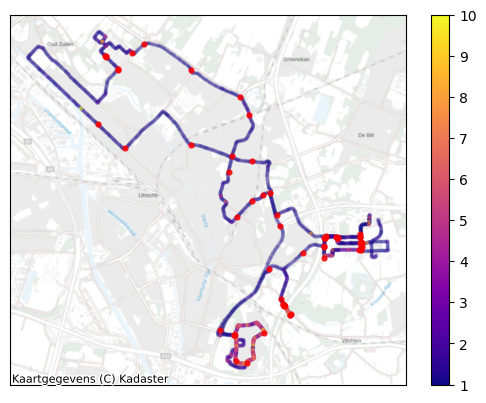

In [ ]:
#* Figure 3: #observations/location

fig, ax2 = plt.subplots()
node_gdf.dropna()[node_gdf['no_observations'] <= 10].plot(column = 'no_observations', figsize=(6.5,5), legend=True, ax=ax2,
             markersize=4, cmap=cmap, alpha=0.1)
node_gdf.dropna()[(node_gdf['no_observations'] > 4) & (node_gdf['no_observations'] <= 10)].plot(column = 'no_observations', figsize=(6.5,5), ax=ax2,
             markersize=4, cmap=cmap, norm = mpl.colors.Normalize(vmin=1, vmax=10), alpha=0.4)
node_gdf.dropna()[node_gdf['no_observations'] > 10].plot(color='red', figsize=(6.5,5), ax=ax2,
             markersize=12, alpha=0.8)
# ax2.set_title('dBA Measurement Scatter')

for ax in [ax2]:
    ax.set_xticks([]); ax.set_yticks([])
    cx.add_basemap(ax, source=cx.providers.nlmaps.grijs, crs=gdf.crs)


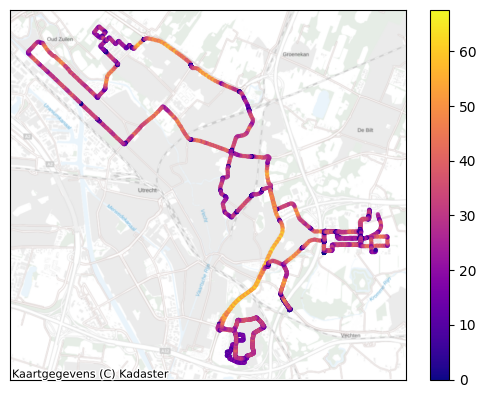

In [ ]:
#* Figure 4: speed/location
fig, ax1 = plt.subplots()

gdf.plot(column = 'speed', figsize=(6.5,5), legend=True, ax=ax1, alpha=0.4,
              markersize=4, cmap=cmap)

for ax in [ax1]:
    ax.set_xticks([]); ax.set_yticks([])
    cx.add_basemap(ax, source=cx.providers.nlmaps.grijs, crs=gdf.crs)


0.6937696652361609


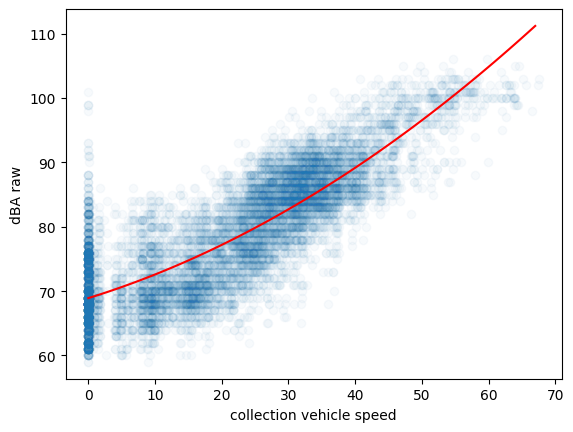

0.6884178596121959


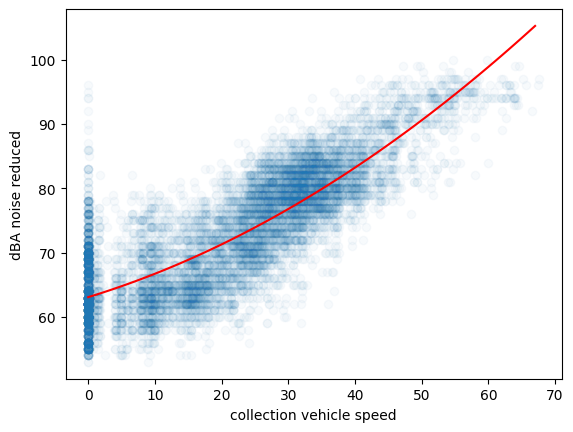

In [ ]:
#* Figure 5: a. regression curve dBA_raw; b. regression curve dBA_noise_red
x_range = np.arange(round(gdf['speed'].min()), round(gdf['speed'].max()))

print(regression_raw['score'])
fig, ax = plt.subplots()
m = regression_raw['full_model']
plt.scatter(gdf['speed'], gdf['dBA_raw'], alpha=0.03)
plt.plot(x_range, m.predict(pp.PolynomialFeatures().fit_transform(x_range.reshape((-1,1)))), color='red')
plt.xlabel('collection vehicle speed'); plt.ylabel('dBA raw')
plt.show()

print(regression_dual['score'])
fig, ax = plt.subplots()
m = regression_dual['full_model']
plt.scatter(gdf['speed'], gdf['dBA_noise_red'], alpha=0.03)
plt.plot(x_range, m.predict(pp.PolynomialFeatures().fit_transform(x_range.reshape((-1,1)))), color='red')
plt.xlabel('collection vehicle speed'); plt.ylabel('dBA noise reduced')
plt.show()

<Axes: ylabel='dBA'>

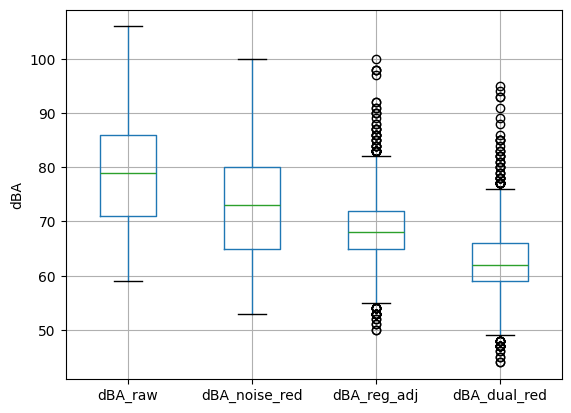

In [ ]:
#* Figure 6: boxplot for each dBA column
gdf.boxplot(column=['dBA_raw', 'dBA_noise_red', 'dBA_reg_adj', 'dBA_dual_red'], ylabel='dBA')
